In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import glob
import os 
from random import shuffle
from nlpia.loaders import get_data

def pre_process_data(filepath):
    positive_path = os.path.join(filepath,'pos')
    negative_path = os.path.join(filepath,'neg')
    pos_label = 1
    neg_label = 0
    dataset = []
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset
dataset = pre_process_data(r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\train')
dataset[0:5]

C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version.

[(1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\8590_7.txt'),
 (1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\9727_7.txt'),
 (0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\9560_1.txt'),
 (0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\5410_1.txt'),
 (1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\4985_10.txt')]

In [3]:
#加载谷歌预训练词向量
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
word_vector=KeyedVectors.load_word2vec_format(r'D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz',binary=True)
tokenizer=TreebankWordTokenizer()

INFO:gensim.models.utils_any2vec:loading projection weights from D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.utils_any2vec:loaded (3000000, 300) matrix from D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz


In [4]:
#划分数据集
import numpy as np

split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]



def token_and_vectorize(filename,tokenizers):       #将句子转换为词向量
    sample_vec=[]
    with open(filename,'r',encoding='utf-8') as f:
        tokens=tokenizer.tokenize(f.read())
        for token in tokens:
            try:
                sample_vec.append(word_vector[token])
            except:
                pass
    return sample_vec


def collect_expected(dataset):       #得到标签
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

def pad_trunc(data,maxlen=400):      #将每个句子的词向量长度规范到400
    zero_vector=[]
    for _ in range(len(data[0])):
        zero_vector.append(0.0)
    if len(data)>maxlen:
        temp=data[:maxlen]
    elif len(data)<maxlen:
        temp=data
        additional_elems=maxlen-len(data)
        for _ in range(additional_elems):
            temp.append(zero_vector)
    else:
        temp=data
    return temp



def data_generator(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if (i % batchsize==0 and X and Y) or (i==len(data_store)):
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)

In [5]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,SimpleRNN
import math



import math

#设置CNN参数
num_netrons = 50
maxlen = 400
batch_size = 32 
embedding_dim = 300    #词向量长度
filters = 250
kernel_size = 3
hidden_dim = 250
epochs = 2

model = Sequential()
model.add(SimpleRNN(num_netrons,return_sequences=True,input_shape=(maxlen,embedding_dim)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

X_test=data_generator(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)

trainlen = len(trainData)
testlen = len(testData)

history=model.fit(data_generator(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 400, 50)           17550     
_________________________________________________________________
dropout (Dropout)            (None, 400, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 37,551
Trainable params: 37,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
625/625 [==============================] - 174s 279ms/step - loss: 0.5331 - accuracy: 0.7362 - val_loss: 0.4261 - val_accuracy: 0.8188
Epoch 2/3
625/625 [==============================] - 117s 188ms/step - loss: 0.3934 - accuracy: 0.8252 - 

<AxesSubplot:>

(0.0, 1.0)

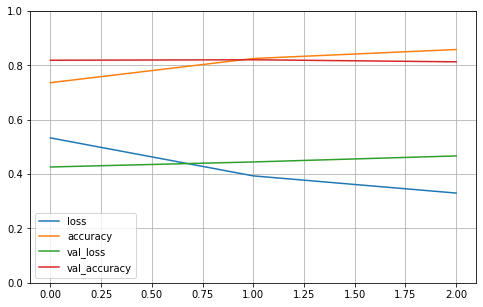

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# 建立更大的网络


In [9]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,SimpleRNN
import math

#设置CNN参数
maxlen = 400
batch_size = 32 
embedding_dim = 300    #词向量长度
filters = 250
kernel_size = 3
hidden_dim = 250
epochs = 2
num_netrons = 100

model = Sequential()
model.add(SimpleRNN(num_netrons,return_sequences=True,input_shape=(maxlen,embedding_dim)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile('rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

trainlen = len(trainData)
testlen = len(testData)

X_test=data_generator(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)


history=model.fit(data_generator(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 400, 100)          40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 40001     
Total params: 80,101
Trainable params: 80,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
625/625 [==============================] - 117s 187ms/step - loss: 0.6913 - accuracy: 0.6736 - val_loss: 0.5371 - val_accuracy: 0.7504
Epoch 2/3
625/625 [==============================] - 119s 190ms/step - loss: 0.4456 - accuracy: 0.8051 

<AxesSubplot:>

(0.0, 1.0)

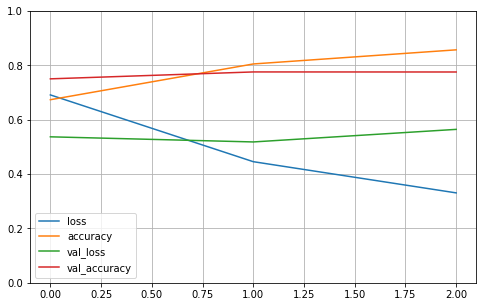

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [11]:
#保存模型

model_structure = model.to_json()
with open(r'D:\深度学习模型\nlp_8.5_rnn_model.json','w')as f:
    f.write(model_structure)
model.save_weights(r'D:\深度学习模型\nlp_8.5_rnn_weight.h5')

1795

In [7]:
#加载模型

from keras.models import model_from_json

with open(r'D:\深度学习模型\nlp_7.4_cnn_model.json','r')as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(r'D:\深度学习模型\nlp_7.4_cnn_weight.h5')

In [9]:
#测试
from nltk.tokenize import TreebankWordTokenizer
import numpy as np
tokenizer = TreebankWordTokenizer()
file1 = r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\test\pos\5_7.txt'
vec_list = token_and_vectorize(file1,tokenizer)

def reshape_400(list):
    zero_list = [0.0 for i in range(len(list[0]))]
    if len(list)>400:
        temp = list[:400]
    elif len(list)<400:
        temp = list
        for i in range(400-len(list)):
            temp.append(zero_list)
    else:
        temp = list
    return temp
test_vec_list = reshape_400(vec_list)

test_vec = np.reshape(test_vec_list,(1,400,300))

model.predict(test_vec)
model.predict_classes(test_vec)    #     pos_label = 1 ,neg_label = 0

array([[1]])

# 双向RNN

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,SimpleRNN
from keras.layers.wrappers import Bidirectional
import math


#设置CNN参数
num_netrons = 10
maxlen = 100
batch_size = 32 
embedding_dim = 300    #词向量长度
filters = 250
kernel_size = 3
hidden_dim = 250
epochs = 2

model = Sequential()
model.add(Bidirectional(SimpleRNN(num_netrons,return_sequences=True,input_shape=(maxlen,embedding_dim))))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()

X_test=data_generator(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)

trainlen = len(trainData)
testlen = len(testData)

history=model.fit(data_generator(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Epoch 1/3
625/625 [==============================] - 104s 166ms/step - loss: 0.5459 - accuracy: 0.7137 - val_loss: 0.4989 - val_accuracy: 0.7618
Epoch 2/3
625/625 [==============================] - 55s 88ms/step - loss: 0.4613 - accuracy: 0.7844 - val_loss: 0.4844 - val_accuracy: 0.7682
Epoch 3/3
625/625 [==============================] - 55s 88ms/step - loss: 0.4393 - accuracy: 0.7976 - val_loss: 0.4829 - val_accuracy: 0.7740


<AxesSubplot:>

(0.0, 1.0)

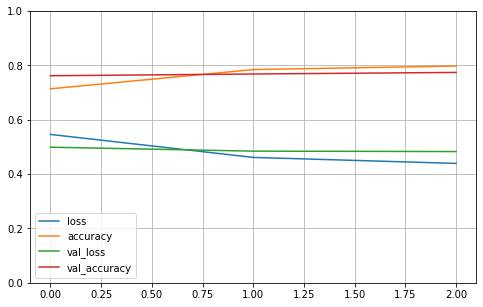

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [10]:
#测试
from nltk.tokenize import TreebankWordTokenizer
import numpy as np
tokenizer = TreebankWordTokenizer()
file1 = r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\test\pos\5_7.txt'
vec_list = token_and_vectorize(file1,tokenizer)

def reshape_100(list):
    zero_list = [0.0 for i in range(len(list[0]))]
    if len(list)>100:
        temp = list[:100]
    elif len(list)<100:
        temp = list
        for i in range(100-len(list)):
            temp.append(zero_list)
    else:
        temp = list
    return temp
test_vec_list = reshape_100(vec_list)

test_vec = np.reshape(test_vec_list,(1,100,300))

model.predict(test_vec)
model.predict_classes(test_vec)    #     pos_label = 1 ,neg_label = 0

array([[0.7520733]], dtype=float32)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1]])